# Parallel Coordinates Plots
Parallel coordinates plots (also known as parallel axis plots) are a common way to visualize many-dimensional data. There are many different tools that can be used to create parallel coordinates plots in Python. For example, Pandas has a built-in version, as demonstrated in the [MOEA Diagnostics page](https://reedgroup.github.io/FigureLibrary/MOEADiagnostics.html) of this manual. There are also many different posts on the Water Programming Blog that demonstrate different ways to create parallel coordinates plots in Python as well as several GUI-based visualization engines (e.g., [Lau 2020](https://waterprogramming.wordpress.com/2020/11/09/parallel-axis-plots-for-the-absolute-beginner/), [Lau 2022](https://waterprogramming.wordpress.com/2022/09/14/fisheries-training-part-2-tradeoff-visualization-and-introduction-to-j3/), [Dircks 2020](https://waterprogramming.wordpress.com/2020/08/10/using-rhodium-for-exploratory-modeling/), [Trindade 2018](https://waterprogramming.wordpress.com/2018/05/18/creating-parallel-axis-plots-with-multiple-datasets-color-gradients-and-brushing-in-python/), [Gupta 2018](https://waterprogramming.wordpress.com/2018/11/05/introduction-to-discoverydv/), and more.

So why the need for this figure library entry? In my experience, the pre-packaged functions for creating parallel coordinates plots (e.g., Pandas) are great for getting a quick-and-dirty look at the data, but they are insufficiently flexible to create more complex and aesthetically pleasing figures. When it comes time to create figures for papers and presentations, I have generally had to start from scratch to create a parallel coordinates plot that suits my particular needs. I imagine this is true for many other Reed Group members and other researchers as well. 

The goal of this page is to present a baseline set of scripts for creating flexible and attractive parallel coordinates plots. The functions below are capable of applying a range of customizations, such as:
1. Automatic normalization of data consistent with user-selected direction of preference for parallel axes ("top" or "bottom") and user-selected direction of optimization preference for each axis ("min" or "max")
2. Support for user-defined continuous or categorical color palettes, and choice of which axis to color lines by
3. Choice of which axis to order lines by (i.e., how to stack overlapping lines)
4. Automated solution brushing based on satisficing criteria for one or more axes.

My hope is that others will add to this over time as new use cases arise so that we can all benefit from improved flexibility & functionality and not have to reinvent the wheel each time.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from pandas.plotting import parallel_coordinates

figsize = (11,6)
fontsize = 14

In [2]:
### get dataset. This is a Pareto set after reevaluation from Hamilton et al, 2023, (In review).
objs = pd.read_csv('example_data/objs_wcu_pareto_5objs.csv', delimiter=', ')
columns_axes = ['n_p','cwg_p','ap_p', 'cwg_np','cog_wp_p90']
axis_labels = ['Number of\npartners', 'Captured water\ngain (GL/yr)', 'Pumping reduction\n(GL/yr)', 
              'Captured water\ngain for non-\npartners (GL/yr)','Cost of gains for\nworst-off partner\n($/ML)']
objs = objs.loc[:, columns_axes]

### as in paper, map all costs >1000 to $1000 for visual clarity
objs['cog_wp_p90'].loc[objs['cog_wp_p90'] > 1000] = 1000
objs

/home/alh/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,n_p,cwg_p,ap_p,cwg_np,cog_wp_p90
0,3,65.286506,25.517769,23.581953,119.515925
1,14,83.519969,60.988011,10.534398,261.605829
2,16,88.828797,64.907146,5.730221,1000.000000
3,17,92.460681,68.455763,-9.325362,1000.000000
4,12,92.651047,58.407270,13.067463,1000.000000
...,...,...,...,...,...
369,8,86.194462,51.207598,17.240311,218.698388
370,9,106.223722,47.046693,-4.389908,290.474609
371,11,77.769762,40.167874,20.107271,253.288096
372,11,89.655118,53.916342,15.455185,225.967740


In [24]:
### function to normalize data based on direction of preference and whether each objective is minimized or maximized
###   -> output dataframe will have values ranging from 0 (which maps to bottom of figure) to 1 (which maps to top)
def reorganize_objs(objs, columns_axes, ideal_direction, minmaxs):
    assert ideal_direction in ['top','bottom']
    
    if minmaxs is None:
        minmaxs = ['max']*len(columns_axes)
        
    objs_reorg = objs[columns_axes]
    if ideal_direction == 'bottom':
        tops = objs_reorg.min(axis=0)
        bottoms = objs_reorg.max(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, -1] = (objs_reorg.iloc[:, -1] - objs_reorg.iloc[:, -1].min(axis=0)) / (objs_reorg.iloc[:, -1].max(axis=0) - objs_reorg.iloc[:, -1].min(axis=0))
    elif ideal_direction == 'top':
        tops = objs_reorg.max(axis=0)
        bottoms = objs_reorg.min(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i] - objs_reorg.iloc[:, i].min(axis=0)) / (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))

    return objs_reorg, tops, bottoms


### function to get color based on continuous color map or categorical map
def get_color(value, color_by_continuous, color_palette_continuous, color_by_categorical, color_dict_categorical):
    ### color method cannot be both continuous and categorical
    assert color_by_continuous is None or color_by_categorical is None
    
    if color_by_continuous is not None:
        color = cm.get_cmap(color_palette_continuous)(value)
    elif color_by_categorical is not None:
        color = color_dict_categorical[value]
    return color

### function to get zorder value for ordering lines on plot. This works by binning a given axis' values and mapping to discrtete classes.
def get_zorder(norm_value, zorder_num_classes, zorder_direction):
    assert zorder_direction in ['ascending', 'descending']
    
    xgrid = np.arange(0, 1.001, 1/zorder_num_classes)
    if zorder_direction == 'ascending':
        return 4 + np.sum(norm_value > xgrid)
    elif zorder_direction == 'descending':
        return 4 + np.sum(norm_value < xgrid)
    
        

### customizable parallel coordinates plot
def custom_parallel_coordinates(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None, brushing_dict=None, 
                                color_by_continuous=None, color_palette_continuous=None, colorbar_ticks_continuous=None, 
                                color_by_categorical=None, color_palette_categorical=None, color_dict_categorical=None,
                                zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', 
                                alpha_base=0.8, lw_base=1.5, fontsize=14, figsize=(11,6)):
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        axis_labels = column_axes
    
    fig,ax = plt.subplots(1,1,figsize=figsize, gridspec_kw={'hspace':0.1, 'wspace':0.1})

    ### reorganize & normalize objective data
    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    ### apply any brushing criteria
    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        ### iteratively apply all brushing criteria to get satisficing set of solutions
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] >= threshold)

            ### add rectangle patch to plot to represent brushing
            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            if ideal_direction == 'top' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
            elif ideal_direction == 'top' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            if ideal_direction == 'bottom' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            elif ideal_direction == 'bottom' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                    
            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)
    
    ### loop over all solutions/rows & plot on parallel axis plot
    for i in range(objs_reorg.shape[0]):
        if color_by_continuous is not None:
            color = get_color(objs_reorg[columns_axes[color_by_continuous]].iloc[i], color_by_continuous, 
                              color_palette_continuous, color_by_categorical, color_dict_categorical)
        elif color_by_categorical is not None:
            color = get_color(objs[color_by_categorical].iloc[i], color_by_continuous, color_palette_continuous, color_by_categorical, color_dict_categorical)
                        
        ### order lines according to ascending or descending values of one of the objectives?
        if zorder_by is None:
            zorder = 4
        else:
            zorder = get_zorder(objs_reorg[columns_axes[zorder_by]].iloc[i], zorder_num_classes, zorder_direction)
        ### apply any brushing?
        if brushing_dict is not None:
            if satisfice.iloc[i]:
                alpha = alpha_base
                lw = lw_base
            else:
                alpha = 0.1
                lw = 1
                zorder = 2
        else:
            alpha = alpha_base
            lw = lw_base
            
        ### loop over objective/column pairs & plot lines between parallel axes
        for j in range(objs_reorg.shape[1]-1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j+1]]
            x = [j, j+1]
            alpha=alpha
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)
            
            
    ### add top/bottom ranges
    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', zorder=5, fontsize=fontsize)
        if j == len(columns_axes)-1:
            ax.annotate(str(round(bottoms[j])) + '+', [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)    
        else:
            ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)    

        ax.plot([j,j], [0,1], c='k', zorder=1)
    
    ### other aesthetics
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center', rotation=90, fontsize=fontsize)

    ax.set_xlim(-0.4, 4.2)
    ax.set_ylim(-0.4,1.1)
    
    for i,l in enumerate(axis_labels):
        ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)
    ax.patch.set_alpha(0)
    

    ### colorbar
    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(), vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4, label=axis_labels[color_by_continuous], pad=0.03, alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)  
    elif color_by_categorical is not None:
        leg = []
        for label,color in color_dict_categorical.items():
            leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))
        _ = ax.legend(handles=leg, loc='lower center', ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5,-0.07], frameon=False, fontsize=fontsize)

            
            

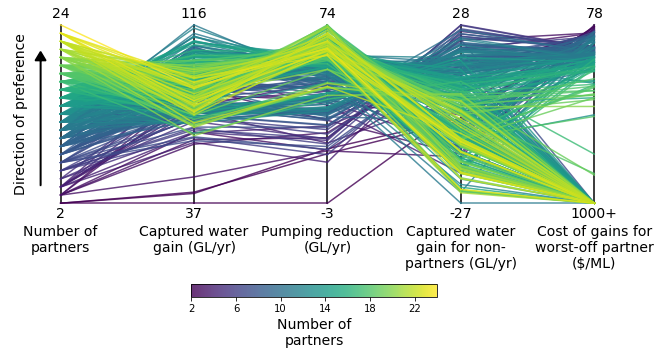

In [7]:
### basic parallel axis plot
custom_parallel_coordinates(objs, columns_axes=objs.columns, axis_labels = axis_labels, color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], colorbar_ticks_continuous=range(2,25,4))

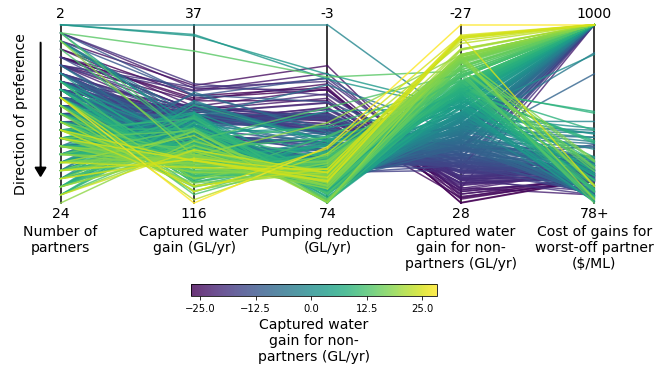

In [8]:
### flip direction of preference & color/order by axis 3 (note zero-indexing; Captured Water Gain for Non-partners)
custom_parallel_coordinates(objs, columns_axes=objs.columns, axis_labels = axis_labels, color_by_continuous=3, zorder_by=3, ideal_direction='bottom',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], colorbar_ticks_continuous=[-25,-12.5,0,12.5,25])

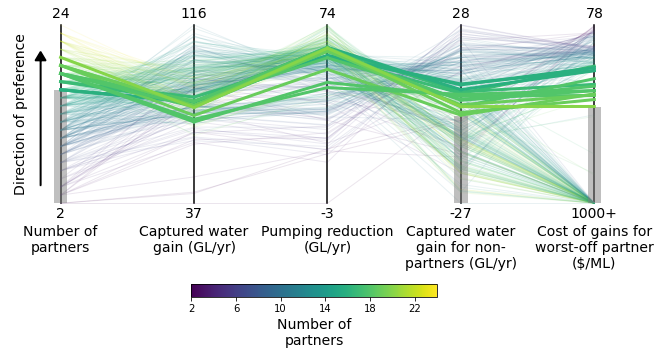

In [9]:
### basic parallel axis plot with brushing. Grey rectangles cover filtered-out solutions based on user-defined brushing criteria.
custom_parallel_coordinates(objs, columns_axes=objs.columns, axis_labels = axis_labels, color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 1, lw_base=3, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], colorbar_ticks_continuous=range(2,25,4),
                            brushing_dict = {0: (16, '>='), 3: (0, '>='), 4: (500, '<')})

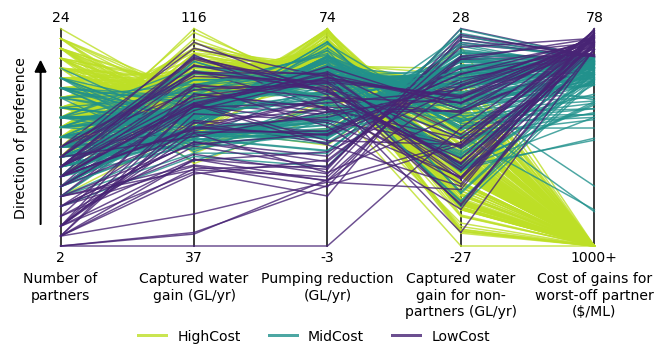

In [20]:
### Now color by a categorical variable that isnt one of the axes
color_dict_categorical = {'HighCost': cm.get_cmap('viridis')(0.9), 'MidCost': cm.get_cmap('viridis')(0.5), 'LowCost': cm.get_cmap('viridis')(0.1)}
objs['Set'] = ['HighCost' if c>=1000 else 'MidCost' if c>=200 else 'LowCost' for c in objs['cog_wp_p90']]

custom_parallel_coordinates(objs, columns_axes=columns_axes, axis_labels = axis_labels, zorder_by=4, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], colorbar_ticks_continuous=range(2,25,4),
                            color_by_categorical = 'Set', color_dict_categorical=color_dict_categorical)

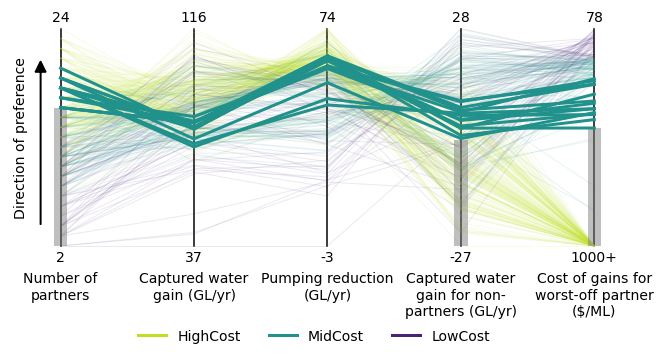

In [25]:
### Now color by a categorical variable that isnt one of the axes, with brushing
color_dict_categorical = {'HighCost': cm.get_cmap('viridis')(0.9), 'MidCost': cm.get_cmap('viridis')(0.5), 'LowCost': cm.get_cmap('viridis')(0.1)}
objs['Set'] = ['HighCost' if c>=1000 else 'MidCost' if c>=200 else 'LowCost' for c in objs['cog_wp_p90']]

custom_parallel_coordinates(objs, columns_axes=columns_axes, axis_labels = axis_labels, zorder_by=4, ideal_direction='top',
                            alpha_base=1, lw_base=3, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], colorbar_ticks_continuous=range(2,25,4),
                            color_by_categorical = 'Set', color_dict_categorical=color_dict_categorical,
                            brushing_dict = {0: (16, '>='), 3: (0, '>='), 4: (500, '<')})